# 1. Install dependencies and bring in data.

In [4]:
!pip install tensorflow pandas matplotlib scikit-learn

In [5]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df= pd.read_csv('/content/sample_data/train.csv')

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df.iloc[5]['comment_text']

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [9]:
df[df.columns[2:]].iloc[5]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 5, dtype: int64

# 2. Preprocessing

In [10]:
from tensorflow.keras.layers import TextVectorization

In [11]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [12]:
MAX_FEATURES = 200000 #number of words in the vocab

In [13]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800,output_mode='int')

In [14]:
vectorizer.adapt(x.values)

In [15]:
vectorizer("Life is great, this is comment toxicity detector")[:9]

<tf.Tensor: shape=(9,), dtype=int64, numpy=array([  306,     9,   275,    14,     9,   204, 14797, 22488,     0])>

In [16]:
vectorized_text = vectorizer(x.values)

In [17]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [18]:
#creating a tensorflow data pipeline, #MCSHBAP-map,cache,shuffle,batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks

In [19]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [20]:
batch_x.shape

(16, 1800)

In [21]:
batch_y.shape

(16, 6)

In [22]:
len(dataset) #number of batches

9974

In [23]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [24]:
print(len(train),',', len(val),',', len(test))

6981 , 1994 , 997


In [25]:
train_generator = train.as_numpy_iterator()

In [26]:
train_generator.next()

(array([[  528,     3,     2, ...,     0,     0,     0],
        [ 1211,    12,     9, ...,     0,     0,     0],
        [ 2859,     4, 16089, ...,     0,     0,     0],
        ...,
        [   84,    50,    10, ...,     0,     0,     0],
        [46551,    46,    33, ...,     0,     0,     0],
        [ 3681,  4426,     7, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 3. Create Sequential Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [28]:
model = Sequential()
# create the embedding layer
model.add(Embedding(MAX_FEATURES + 1, 32))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32,activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# final layer
model.add(Dense(6, activation='sigmoid'))

In [29]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [31]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 981s 139ms/step - loss: 0.0645 - val_loss: 0.0460
Epoch 2/5
6981/6981 [==============================] - 872s 125ms/step - loss: 0.0465 - val_loss: 0.0400
Epoch 3/5
6981/6981 [==============================] - 796s 114ms/step - loss: 0.0416 - val_loss: 0.0383
Epoch 4/5
6981/6981 [==============================] - 788s 113ms/step - loss: 0.0372 - val_loss: 0.0329
Epoch 5/5
6981/6981 [==============================] - 788s 113ms/step - loss: 0.0333 - val_loss: 0.0280


In [32]:
from matplotlib import pyplot as plt

In [33]:
history.history

{'loss': [0.06452333927154541,
  0.04654636234045029,
  0.04156605526804924,
  0.037169117480516434,
  0.03334062546491623],
 'val_loss': [0.04595804214477539,
  0.04002828896045685,
  0.03825603798031807,
  0.0329364538192749,
  0.027979133650660515]}

<Figure size 800x500 with 0 Axes>

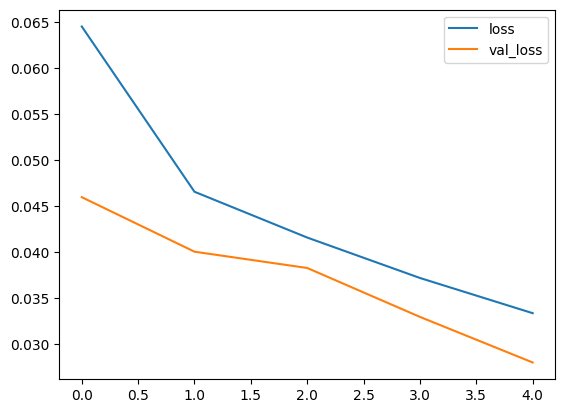

In [34]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 4. Make Predictions

In [35]:
text = vectorizer('you look good today')
print(text,'shape-',text.shape)

tf.Tensor([  7 147  98 ...   0   0   0], shape=(1800,), dtype=int64) shape- (1800,)


In [36]:
np.array([text])

array([[  7, 147,  98, ...,   0,   0,   0]])

In [37]:
np.expand_dims(text,0)

array([[  7, 147,  98, ...,   0,   0,   0]])

In [38]:
#res =  model.predict(np.array([text]))
res = model.predict(np.expand_dims(text,0))
res

1/1 [==============================] - 1s 916ms/step


array([[1.4605416e-03, 9.7574475e-14, 2.4880546e-05, 7.6970178e-07,
        7.1079572e-05, 5.2965379e-06]], dtype=float32)

In [39]:
text = vectorizer('you freaking suck!')

In [40]:
res = model.predict(np.expand_dims(text,0))
res

1/1 [==============================] - 0s 51ms/step


array([[0.9993401 , 0.18813935, 0.98504806, 0.00629653, 0.7929528 ,
        0.0209295 ]], dtype=float32)

In [41]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [42]:
batch_x, batch_y =  test.as_numpy_iterator().next()

In [43]:
model.predict(batch_x)

1/1 [==============================] - 0s 62ms/step


array([[3.35574560e-02, 8.88355167e-09, 8.98483268e-04, 1.55691116e-04,
        2.61757150e-03, 4.22045967e-04],
       [3.58666852e-02, 2.58546944e-08, 1.36478618e-03, 3.11470183e-04,
        3.90986959e-03, 7.81343377e-04],
       [1.08369513e-05, 6.23632222e-23, 1.27204896e-08, 6.08764428e-11,
        7.46345918e-08, 1.39698908e-09],
       [4.96077446e-05, 3.27931586e-20, 1.07075223e-07, 1.06308551e-09,
        5.04354148e-07, 1.30062849e-08],
       [5.23515737e-05, 4.82828264e-20, 1.17619770e-07, 1.51978496e-09,
        6.26232463e-07, 1.96736032e-08],
       [2.57864400e-07, 6.17246855e-30, 7.70970995e-11, 1.25841771e-14,
        3.60873165e-10, 1.66549413e-12],
       [4.19459641e-02, 7.78362832e-08, 2.30537192e-03, 4.32032888e-04,
        5.47043374e-03, 1.06746447e-03],
       [1.96326175e-04, 1.25411235e-17, 8.39540064e-07, 1.89657694e-08,
        3.80191636e-06, 1.73073957e-07],
       [2.44584430e-06, 1.37780868e-25, 1.74452375e-09, 2.80961712e-12,
        1.04969917e-08, 

In [44]:
(model.predict(batch_x) > 0.5).astype(int)

1/1 [==============================] - 0s 61ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# 5. Evaluate Model

In [45]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [46]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [47]:
for batch in test.as_numpy_iterator():
  x_true, y_true = batch
  yhat =  model.predict(x_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 56ms/step


In [48]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy: {acc.result().numpy()}')

Precision: 0.8945174813270569, Recall:0.8008036613464355,Accuracy: 0.49949848651885986


# 6. Test and Gradio

In [49]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.8 M

In [50]:
import tensorflow as tf
import gradio as gr

In [51]:
model.save('toxicity.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
model = tf.keras.models.load_model('toxicity.h5')

In [79]:
input_str = vectorizer('You suck')

In [80]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 0s 54ms/step


array([[0.99440163, 0.11350465, 0.95741314, 0.00288624, 0.5248789 ,
        0.00854082]], dtype=float32)

In [76]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.45)

    return text

In [77]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs=gr.Textbox()
)

In [78]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://82cc290c57b6d71a4b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
